In [125]:
##### IMPORT ALL PACKAGES #####
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())

##### IMPORT ALL DATA #####
df_bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv') # PRIMARY
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv').drop('Unnamed: 0', axis=1)
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

In [126]:
GENRES_OG = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
GENRES_FULL = [
     'genre_action','genre_adult','genre_adventure','genre_animation','genre_biography','genre_comedy','genre_crime',
     'genre_documentary','genre_drama','genre_family','genre_fantasy','genre_gameshow','genre_history','genre_horror',
     'genre_music','genre_musical','genre_mystery','genre_news','genre_reality_tv','genre_romance','genre_sci_fi',
     'genre_short','genre_sport','genre_talkshow','genre_thriller','genre_war','genre_western']
GENRE_CONVERSION = dict(zip(GENRES_FULL, GENRES_OG))

In [127]:
##### COMBINE AND CLEAN FINANCIAL DATA #####
df_money = df_tn_movie_budgets.loc[:, ['movie', 'production_budget', 'domestic_gross','worldwide_gross']].copy()
production_budget = [float(x.replace('$', '').replace(',','')) for x in df_money.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.worldwide_gross]
df_money = pd.DataFrame([production_budget, domestic_gross, worldwide_gross]).transpose()
df_money.columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
df_money['profit'] = df_money.worldwide_gross - df_money.production_budget
df_money['movie'] = df_tn_movie_budgets.movie
df_money = df_money[['movie','production_budget', 'domestic_gross', 'worldwide_gross', 'profit']]
df_money = df_money.sort_values(by='movie').reset_index(drop=True)
df_genres = df_imdb_title_basics[df_imdb_title_basics['genres'].isna() == False].copy()
for category in GENRES_OG:
    df_genres[category] = [category in x for x in df_genres['genres']]
df_genres.drop(['start_year', 'runtime_minutes', 'genres', 'original_title'], axis=1, inplace=True)

In [129]:
df = pysqldf(''' SELECT * FROM df_imdb_title_basics basics
LEFT JOIN df_genres genres USING (tconst)
LEFT JOIN df_money money ON basics.primary_title == money.movie
LEFT JOIN df_tmdb_movies tmdb ON basics.primary_title == tmdb.original_title;''')

df = df[[
       'tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
       'genre_ids', 'id', 'original_language', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]
df.columns = ['tconst', 'primary_title', 'DELETE1', 'original_title',
       'DELETE2', 'start_year', 'runtime_minutes', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_news', 'genre_reality_tv', 'genre_romance', 'genre_sci_fi',
       'genre_short', 'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war', 'genre_western']
df.drop(['DELETE1', 'DELETE2'], axis=1, inplace=True)

In [132]:
profit_median = []
for g in GENRES_FULL:
    profit_median.append(df.loc[(df[g].isna()==False)&(df.profit.isna()==False)&(df[g]==True), 
                                'profit'].median())
profit_stddev = [] 
for g in GENRES_FULL:
    profit_stddev.append(df.loc[(df[g].isna()==False)&(df.profit.isna()==False)&(df[g]==True), 
                                'profit'].std())
budget_median = [] 
for g in GENRES_FULL:
    budget_median.append(df.loc[(df[g].isna()==False)&(df.production_budget.isna()==False)&(df[g]==True), 
                                'production_budget'].median())
popularity_median = []
for g in GENRES_FULL:
    popularity_median.append(df.loc[(df[g].isna()==False)&(df.popularity.isna()==False)&(df[g]==True),
                                    'popularity'].median())
MINIMUM_VOTES = 10 
voteavg_median = []
for g in GENRES_FULL:
    voteavg_median.append(df.loc[(df[g].isna()==False)&(df.vote_average.isna()==False)&(df[g]==True)&
                                  (df.vote_count>= MINIMUM_VOTES),'vote_average'].median())                  
film_ct = []
for g in GENRES_FULL:
    film_ct.append(df.loc[(df[g].isna()==False)&(df[g]==True),g].sum())

In [238]:
df_genres = pd.DataFrame(GENRES_FULL, columns = ['genre'])
df_genres['profit_median'] = profit_median
#df_genres['profit_stddev'] = profit_stddev#[x/10**7 for x in profit_stddev]
df_genres['budget_median'] = budget_median
df_genres['popularity_median'] = popularity_median
df_genres['voteavg_median'] = voteavg_median
df_genres['film_ct'] = film_ct

QUANTILE_MIN = 0.
quantiles = pd.DataFrame([[df_genres['profit_median'].quantile(QUANTILE_MIN), 
                           #df_genres['profit_stddev'].quantile(1-QUANTILE_MIN), 
                           df_genres['popularity_median'].quantile(QUANTILE_MIN), 
                           df_genres['voteavg_median'].quantile(QUANTILE_MIN),
                           df_genres['film_ct'].quantile(QUANTILE_MIN)]],
                         columns = ['profit_median','popularity_median', 'voteavg_median', 'film_ct'])

df_desirables = df_genres.copy()

for g in df_desirables.genre:
    for q in quantiles:
        #print('\n\n',g,",",q, ',', quantiles[q])
        df_desirables[q] = df_desirables[q].loc[df_desirables[q] >= quantiles[q][0]]
        
df_desirables = df_desirables.dropna().reset_index(drop=True)
df_desirables

,genre,profit_median,budget_median,popularity_median,voteavg_median,film_ct
0,genre_action,26800758.0,35000000.0,3.4580,5.80,10728.0
1,genre_adventure,58702781.5,70000000.0,4.2825,6.10,6704.0
2,genre_animation,110724600.0,70000000.0,3.4120,6.40,2885.0
3,genre_biography,9403192.0,18000000.0,1.8620,6.80,8966.0
4,genre_comedy,15852177.0,20000000.0,2.0915,6.00,25855.0
5,genre_crime,2434356.0,20000000.0,2.9780,5.90,7085.0
6,genre_documentary,6524293.0,12000000.0,0.8585,6.70,52408.0
7,genre_drama,4152584.0,12000000.0,1.9470,6.10,51865.0
8,genre_family,31059560.0,18000000.0,1.3160,6.20,6418.0
9,genre_fantasy,36246127.5,33750000.0,3.8000,5.90,3643.0


Top genres, ordered by the maximum quantiles they fall into: Adventure, Romance, Biography, Comedy, Animation


In [239]:
genres_best = ['genre_adventure', 'genre_romance', 'genre_biography', 'genre_comedy','genre_animation']
genres_desirable = list(df_desirables['genre'])

### Next Steps

- Create new full dataframe that drops movies from undesirable genres. From this dataframe, create basic distributions of profitability. High uncertainty

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 <a list of 23 Text major ticklabel objects>)

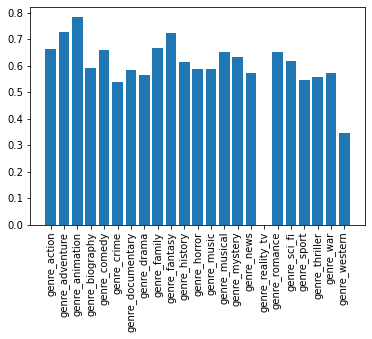

In [240]:
df_desirable = df.copy()
for g in GENRES_FULL:
    if not (g in genres_desirable):
        df_desirable.drop(df_desirable[g].loc[df_desirable[g] == True].index, inplace=True)
        
        
genre = genres_best[0]
category = 'profit'
#print(genre)
#plt.hist(df_desirable.loc[(df[genre]==True) & (df[category].isna()==False)][category], bins=20)
#plt.show()



profit_rates = dict.fromkeys(genres_desirable)
for item in profit_rates.keys(): profit_rates[item] = 0;


for genre in profit_rates.keys():
    ct_positive = 0
    ct_negative = 0
    for movie in df_desirable.loc[(df[genre]==True) & (df[category].isna()==False)][category]:
        if movie > 0:
            ct_positive += 1
        if movie <= 0:
            ct_negative += 1
    profit_rates[genre] = ct_positive / (ct_positive+ct_negative)

#profit_rates

plt.bar(list(profit_rates.keys()), list(profit_rates.values()))
plt.xticks(rotation=90)